In [1]:
import scipy
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = scipy.misc.imresize(img, self.img_res)
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)


In [2]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'cezanne2photo'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
#                 print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
#                                                                         % ( epoch, epochs,
#                                                                             batch_i, self.data_loader.n_batches,
#                                                                             d_loss[0], 100*d_loss[1],
#                                                                             g_loss[0],
#                                                                             np.mean(g_loss[1:3]),
#                                                                             np.mean(g_loss[3:5]),
#                                                                             np.mean(g_loss[5:6]),
#                                                                             elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)
                    print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.imread("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()
        plt.close()

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


C:\Users\kenneth\Anaconda3\lib\site-packages\ipykernel\__main__.py:75: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\kenneth\Anaconda3\lib\site-packages\ipykernel\__main__.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\kenneth\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\kenneth\Anaconda3\li

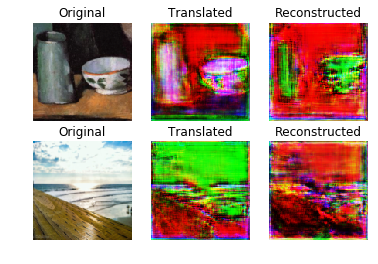

[Epoch 0/10] [Batch 0/525] [D loss: 14.770859, acc:  17%] [G loss: 125.177078, adv: 53.935333, recon: 0.799602, id: 0.697056] time: 0:00:33.366503 


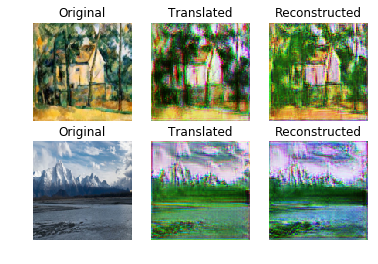

[Epoch 0/10] [Batch 200/525] [D loss: 0.531835, acc:  21%] [G loss: 5.918546, adv: 0.420518, recon: 0.232810, id: 0.191689] time: 0:01:16.220875 


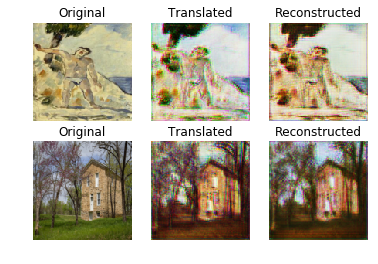

[Epoch 0/10] [Batch 400/525] [D loss: 0.367417, acc:  16%] [G loss: 4.105257, adv: 0.400165, recon: 0.148467, id: 0.182327] time: 0:01:57.951644 


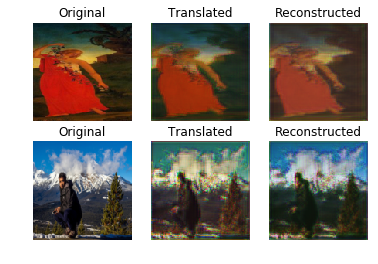

[Epoch 1/10] [Batch 0/525] [D loss: 0.231224, acc:  64%] [G loss: 4.492968, adv: 0.493092, recon: 0.159470, id: 0.189703] time: 0:02:23.943895 


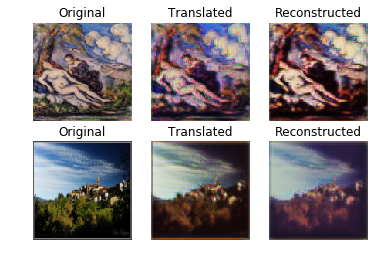

[Epoch 1/10] [Batch 200/525] [D loss: 0.229238, acc:  62%] [G loss: 3.898974, adv: 0.419216, recon: 0.140426, id: 0.118565] time: 0:03:05.100788 


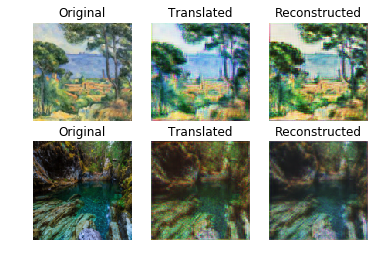

[Epoch 1/10] [Batch 400/525] [D loss: 0.209766, acc:  66%] [G loss: 3.164372, adv: 0.449990, recon: 0.101521, id: 0.142663] time: 0:03:47.889088 


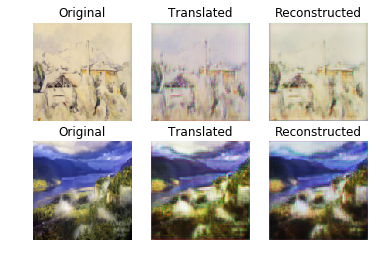

[Epoch 2/10] [Batch 0/525] [D loss: 0.247221, acc:  56%] [G loss: 3.692760, adv: 0.404977, recon: 0.129315, id: 0.137812] time: 0:04:13.450232 


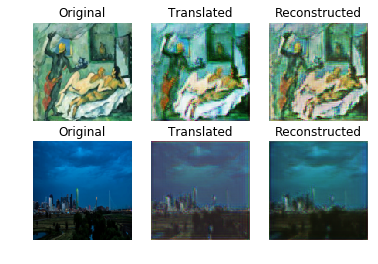

[Epoch 2/10] [Batch 200/525] [D loss: 0.378494, acc:  30%] [G loss: 6.279984, adv: 0.277836, recon: 0.258511, id: 0.137379] time: 0:04:56.048188 


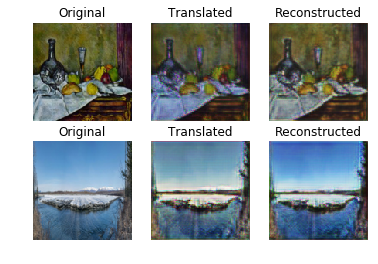

[Epoch 2/10] [Batch 400/525] [D loss: 0.035018, acc: 100%] [G loss: 3.674236, adv: 0.829614, recon: 0.086951, id: 0.147409] time: 0:05:37.101293 


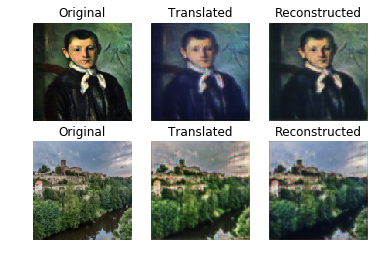

[Epoch 3/10] [Batch 0/525] [D loss: 0.276008, acc:  51%] [G loss: 3.381432, adv: 0.360675, recon: 0.118095, id: 0.161589] time: 0:06:03.530447 


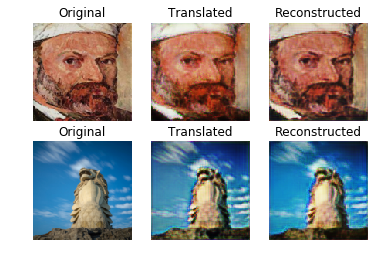

[Epoch 3/10] [Batch 200/525] [D loss: 0.221492, acc:  62%] [G loss: 3.302411, adv: 0.464229, recon: 0.105798, id: 0.134314] time: 0:06:47.463765 


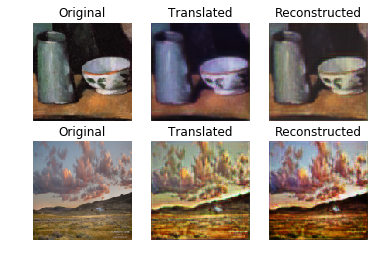

[Epoch 3/10] [Batch 400/525] [D loss: 0.099062, acc:  94%] [G loss: 3.649026, adv: 0.655850, recon: 0.103548, id: 0.143862] time: 0:07:36.022695 


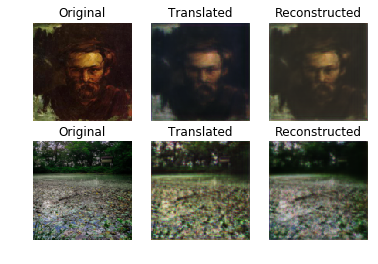

[Epoch 4/10] [Batch 0/525] [D loss: 0.081510, acc:  95%] [G loss: 3.456229, adv: 0.637195, recon: 0.096170, id: 0.131463] time: 0:08:08.449759 


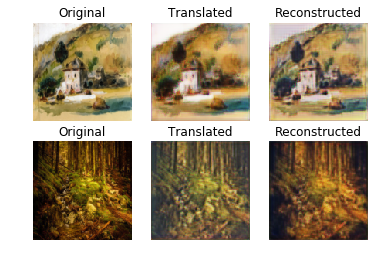

[Epoch 4/10] [Batch 200/525] [D loss: 0.187122, acc:  73%] [G loss: 3.178457, adv: 0.586222, recon: 0.089199, id: 0.132379] time: 0:09:07.970711 


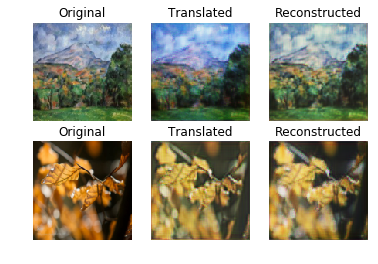

[Epoch 4/10] [Batch 400/525] [D loss: 0.195601, acc:  78%] [G loss: 3.845219, adv: 0.523115, recon: 0.126261, id: 0.159355] time: 0:10:03.426010 


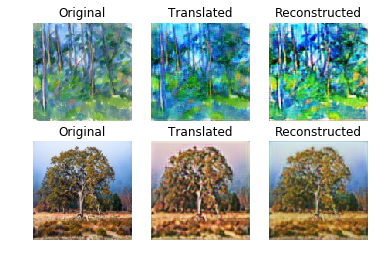

[Epoch 5/10] [Batch 0/525] [D loss: 0.357422, acc:  23%] [G loss: 2.862514, adv: 0.296446, recon: 0.100551, id: 0.107205] time: 0:10:35.971165 


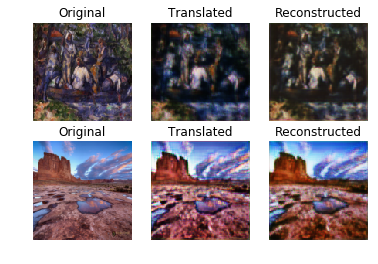

[Epoch 5/10] [Batch 200/525] [D loss: 0.295725, acc:  35%] [G loss: 2.801127, adv: 0.281931, recon: 0.101191, id: 0.102520] time: 0:11:27.093993 


KeyboardInterrupt: 

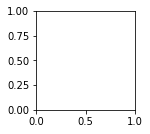

In [3]:
gan = CycleGAN()
gan.train(epochs=10, batch_size=1, sample_interval=200)